# Controlling the resonator (making it jump)

This example continuously reads the phase at a fixed frequency, near the resonator location. It then creates a trigger that causes the resonator to move. It will show as a phase jump followed by a recovery given by the resonator sweep time.

In [1]:
import sys
# sys.path.append('../qick/qick_lib/')
sys.path.append('../soft/')
sys.path.append('../firmware/')

from qick import *
from qick_training import *

from qick.averager_program import QickSweep
from qick.averager_program import QickRegister
from qick.averager_program import merge_sweeps

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftshift
from tqdm.notebook import tqdm

In [2]:
# Initialize Firmware.
soc = QickTrainingSoc('../firmware/qick_training.bit')

# Print information.
soccfg = soc
print(soc)


QICK configuration:

	Board: ZCU216

	Software version: 0.2.175
	Firmware timestamp: Wed Sep  6 15:36:36 2023

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	7 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, envelope memory 4096 samples
		DAC tile 2, blk 0, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	1:	axis_sg_int4_v1 - tProc output 1, envelope memory 4096 samples
		DAC tile 2, blk 1, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	2:	axis_sg_int4_v1 - tProc output 2, envelope memory 4096 samples
		DAC tile 2, blk 2, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	3:	axis_sg_int4_v1 - tProc output 3, envelope memory 4096 samples
		DAC tile 2, blk 3, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, blk 0, 32-bit DDS, fabric=307.200 MHz, f_dds=4915.200 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, blk 2, 32-

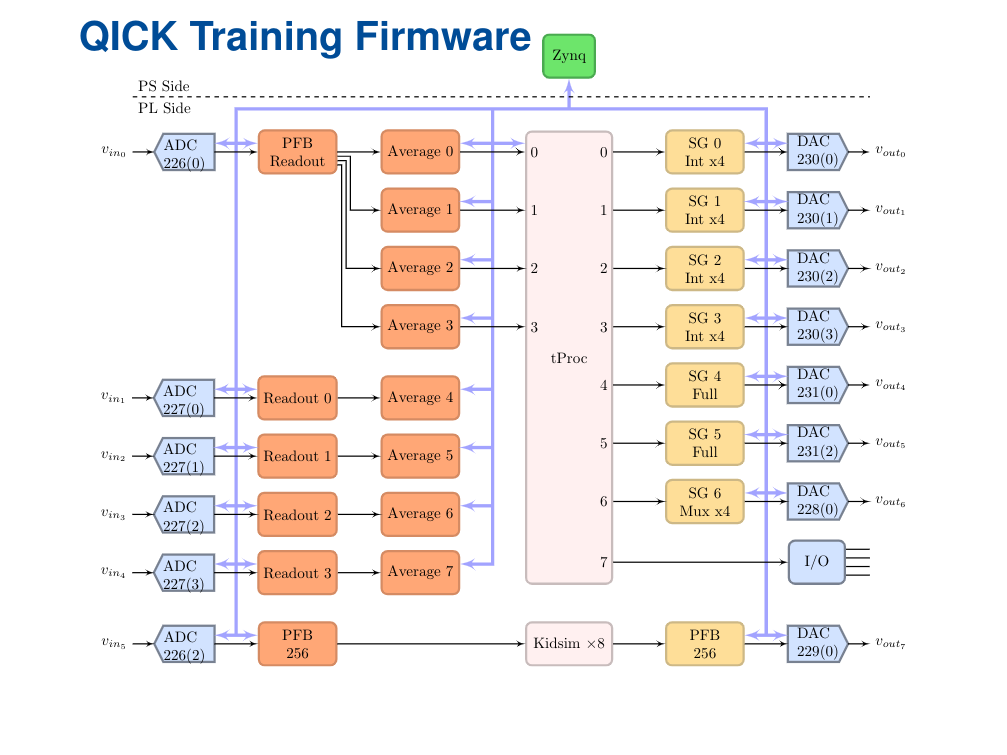

In [3]:
from IPython.display import Image, display
display(Image(filename='images/Qick_training.png', embed=True))

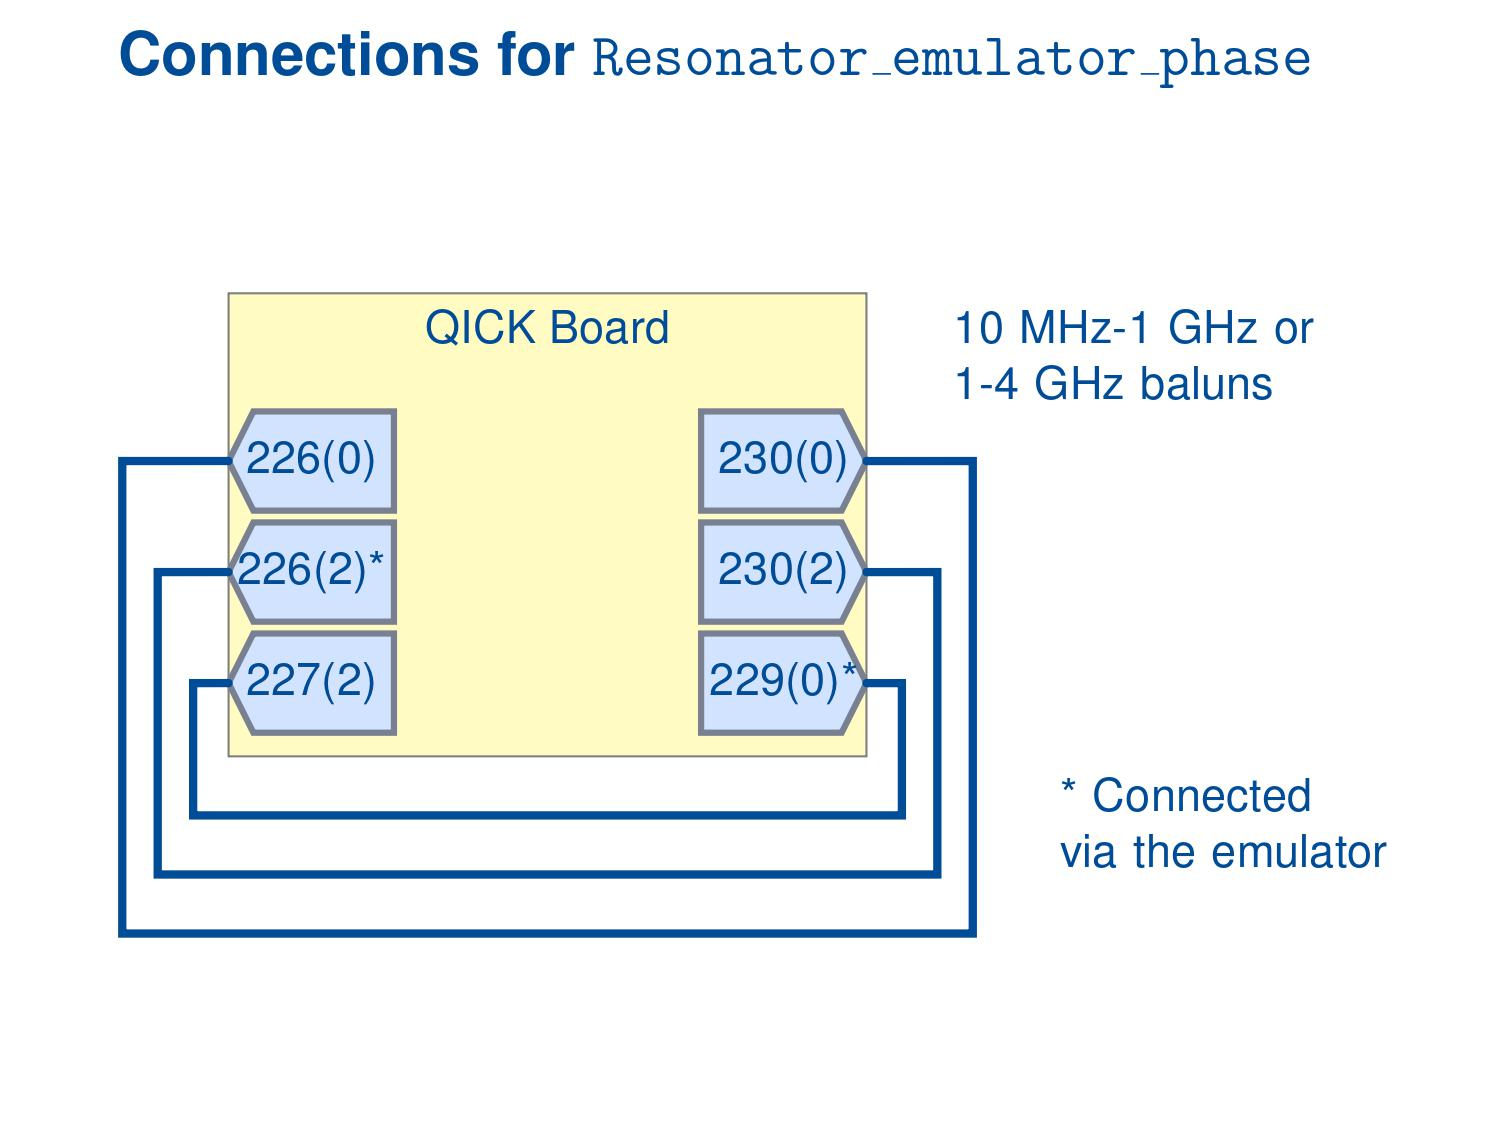

In [5]:
display(Image(filename='images/Connections_Res_emulator.png', embed=True))

In [3]:
######################################
### Build Resonator Emulator Chain ###
######################################
simu = SimuChain(soc,soc['simu'][0], name="226_2 <-> 229_0")

In [4]:
###############################
### Resonator Configuration ###
###############################
simu.qout(3)
#simu.synthesis.qout(1)

# Disable all resonators.
simu.alloff()


### Resonator configuration. Note that some of these config parameters depend on each other, 
### so not every configuration is possible.
cfg = {'sel' : 'resonator', 'freq' : 499.3}
cfg['nstep'] = 1 # 3
cfg['sweep_time'] = 500 # 100, decay time
simu.set_resonator(cfg, verbose=True)

SimuChain: f = 499.3 MHz, fd = -115.09999999999997 MHz, k = 232, fdds = 0.10000000000002274 MHz
AxisKidsimV3: sel        = resonator
AxisKidsimV3: channel    = 232
AxisKidsimV3: lane       = 0
AxisKidsimV3: punct_id   = 29
AxisKidsimV3: iir_c0     = 0.99
AxisKidsimV3: iir_c1     = 0.8
AxisKidsimV3: iir_g      = 0.9045226130653267
AxisKidsimV3: dds_freq   = 0.10000000000002274
AxisKidsimV3: dds_wait   = 4799
AxisKidsimV3: sweep_freq = 0.9
AxisKidsimV3: sweep_time = 500
AxisKidsimV3: nstep      = 1
freq = 683, bval = 6144, slope = 6144, steps = 1, wait = 4799
c0 = 32440, c1 = 26214, g = 29639
sel = 0, punct_id = 29, addr = 0


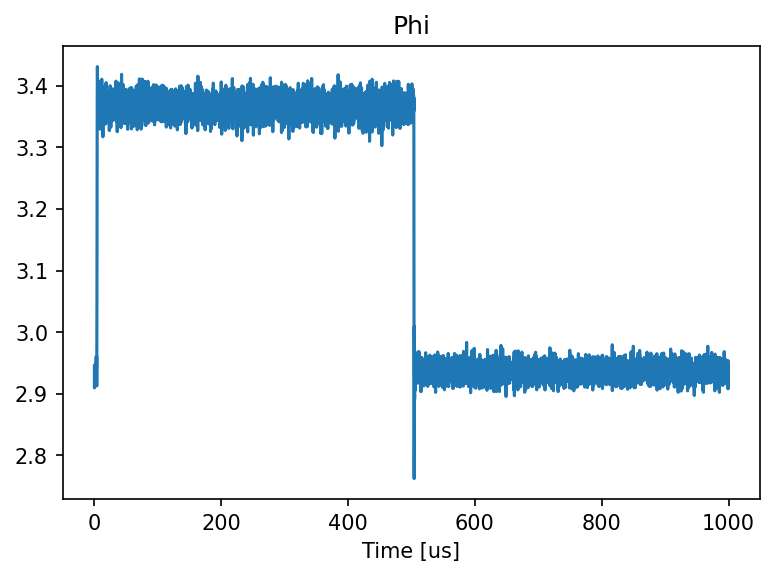

In [5]:
class PhaseFastProgram(AveragerProgram):
    def initialize(self):
        # Set the nyquist zone
        self.declare_gen(ch=self.cfg["gen_ch"], nqz=1)
                        
        # First channel.
        length   = self.us2cycles(self.cfg['pulse_length'],gen_ch=self.cfg['gen_ch'])
        freq_gen = self.freq2reg(self.cfg['pulse_freq'],gen_ch=self.cfg['gen_ch'],ro_ch=self.cfg['ro_ch'])
        self.default_pulse_registers(ch     = self.cfg['gen_ch'],
                                     style  = 'const',
                                     length = length,
                                     freq   = freq_gen,
                                     phase  = 0,
                                     gain   = self.cfg['pulse_gain'])
        
        # Readout.
        self.declare_readout(ch      = self.cfg['ro_ch'], 
                             length  = self.us2cycles(0.7*self.cfg['period'], ro_ch = self.cfg['ro_ch']),
                             freq    = self.cfg['pulse_freq'],                             
                             gen_ch  = self.cfg['gen_ch'])
        
        # Registers.
        self.set_pulse_registers(ch=self.cfg['gen_ch'], phrst=0, mode="periodic")
        
        # Write conditional register.
        self.regwi(0,2,self.cfg['cond_jump'],"Conditional Jump")
        
        # Send pulse out.
        self.pulse(ch=self.cfg["gen_ch"])
        
        # Sync.
        self.synci(self.us2cycles(self.cfg['wait_start']))
    
    def body(self):
        # Apply conditional logic statement: When number is smaller than threshold, skip over playing the pulse.
        self.condj(0,2,'!=',15,'JUMP')
        self.trigger(pins=[4,5,6,7,8,9,10,11]) # play readout pulse
        self.label('JUMP')
        
        self.trigger(adcs=self.ro_chs, pins=[0])                
        self.synci(self.us2cycles(self.cfg['period']))
        
config={"gen_ch"      : 2,
        "ro_ch"       : 6,
        "reps"        : 10000,
        "pulse_length": 10,
        "pulse_gain"  : 30000, # [DAC units]
        "pulse_freq"  : 498, # [MHz]
        "cond_jump"   : 10,
        "period"      : 0.1,
        "wait_start"  : 20
       }

prog = PhaseFastProgram(soccfg, config)
prog.acquire(soc, progress=False)

# Plot data.
nsamp = prog.ro_chs[config['ro_ch']]['length'] # samples for each capture
di = prog.di_buf[0]/nsamp # Averaging
dq = prog.dq_buf[0]/nsamp # Averaging
diq = di + 1j*dq
a = np.abs(diq)
phi = np.angle(diq)
n = config['period']*np.arange(len(di)) # Sampling period

#Plot results.
# plt.figure(dpi=150)
# plt.plot(n,di)
# plt.title("Real Part")

# plt.figure(dpi=150)
# plt.plot(n,dq)
# plt.title("Imaginary Part")

plt.figure(dpi=150)
plt.plot(n,np.unwrap(phi))
plt.xlabel("Time [us]");
plt.title("Phi");